# Installation et import des librairies

- conda install -c conda-forge numpy
- conda install -c conda-forge pandas
- conda install -c anaconda scikit-learn
- conda install -c conda-forge scikit-learn-intelex
- conda install -c anaconda gensim  # python=3.8
- conda install -c conda-forge tensorflow-hub
- pip install --upgrade tensorflow-estimator==2.3.0
- conda install -c conda-forge matplotlib
- conda install -c anaconda seaborn

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import re
import math
import time
import warnings
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## for preprocessing
from sklearn.preprocessing import StandardScaler

## for classification
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import SGDClassifier

## for metrics
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

## for bag-of-words / Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for universal sentence encoder
import tensorflow_hub as hub

## Plotting tools
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

## dump
import joblib

C:\Users\james\anaconda3\envs\p5\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Chargement du jeu de données

In [4]:
data = pd.read_pickle('df_save.pkl')  

In [5]:
data.shape

(10243, 36)

In [6]:
data.columns

Index(['text', 'list_tokens', 'str_tokens', 'Dominant_Topic',
       'Perc_Contribution', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15',
       'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21',
       'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27',
       'topic_28', 'topic_29', 'Tags_list'],
      dtype='object')

# Split

In [7]:
print('Split Dataset')
print('---------------------------------------------------------')
X_train, X_test = train_test_split(data, random_state=0, test_size=0.2)
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))

Split Dataset
---------------------------------------------------------
X_train: (8194, 36)
X_test: (2049, 36)


In [8]:
y_train = X_train[['Tags_list']]
y_test = X_test[['Tags_list']]
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))

y_train: (8194, 1)
y_test: (2049, 1)


# Target encoder

In [9]:
mlb = MultiLabelBinarizer()

In [10]:
y_train = mlb.fit_transform(y_train.Tags_list)

In [11]:
y_test = mlb.transform(y_test.Tags_list)

# Extraction de tags

In [12]:
def check_overfitting(model, X_train, limit):
    grid = GridSearchCV(model,
                        param_grid={},
                        scoring='f1_samples',
                        verbose=1,
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True,
                        refit=True)
    
    grid.fit(X_train, y_train)
    train_score = grid.cv_results_['mean_train_score'][0]
    test_score = grid.cv_results_['mean_test_score'][0]

    print('train_score:', train_score)
    print('test_score:', test_score)
    print('')

    if (train_score - test_score) <= limit:
        print('model is not ovefitting')
    else:
        print('model is ovefitting')
        raise

In [13]:
eval_acc = {}
eval_jac = {}
eval_f1 = {}

def evaluation(case, y_true, y_pred, average):
    global eval_acc, eval_jac, eval_f1
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:",  round(accuracy,3))
    
    # jacard
    jacard = jaccard_score(y_true, y_pred, average=average)
    print('Jacard:', round(jacard,3)) 
    
    # f1
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    print('F1:', round(f1,3)) 
    
    eval_acc[case] = accuracy    
    eval_jac[case] = jacard
    eval_f1[case] = f1

## Approche semi-supervisée

In [14]:
X_train_semi = X_train.loc[:, (X_train.columns != 'text') &
                              (X_train.columns != 'list_tokens') &
                              (X_train.columns != 'str_tokens') &
                              (X_train.columns != 'Tags_list')
                           ]
X_test_semi = X_test.loc[:, (X_test.columns != 'text') &
                            (X_test.columns != 'list_tokens') &
                            (X_test.columns != 'str_tokens') &
                            (X_test.columns != 'Tags_list')
                         ]
print('X_train_semi: ' + str(X_train_semi.shape))
print('X_test_semi: ' + str(X_test_semi.shape))

X_train_semi: (8194, 32)
X_test_semi: (2049, 32)


In [15]:
lda = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', ClassifierChain(SGDClassifier(
        loss='squared_hinge', alpha=1e-2, max_iter=10, early_stopping=True)))
])

In [16]:
check_overfitting(lda, X_train_semi, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


train_score: 0.17185045158515894
test_score: 0.16441381328565735

model is not ovefitting


In [17]:
lda.fit(X_train_semi, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ClassifierChain(base_estimator=SGDClassifier(alpha=0.01,
                                                              early_stopping=True,
                                                              loss='squared_hinge',
                                                              max_iter=10)))])

In [18]:
predicted_semi = lda.predict(X_test_semi)

In [19]:
evaluation('lda', y_test, predicted_semi, 'samples')

Accuracy: 0.082
Jacard: 0.163
F1: 0.193


## Approche supervisée

In [20]:
nb_features = 100

### Bag of words

In [21]:
X_train_bow = X_train.str_tokens
X_test_bow = X_test.str_tokens

In [22]:
bow = Pipeline([('bow', CountVectorizer(max_features=nb_features, ngram_range=(1, 2))),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', ClassifierChain(SGDClassifier(
                    loss='squared_hinge', alpha=1e-2, max_iter=10, early_stopping=True)))
                ])

In [23]:
check_overfitting(bow, X_train_bow, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


train_score: 0.3400274880728058
test_score: 0.3159612910451366

model is not ovefitting


In [24]:
bow.fit(X_train_bow, y_train)

Pipeline(steps=[('bow', CountVectorizer(max_features=100, ngram_range=(1, 2))),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 ClassifierChain(base_estimator=SGDClassifier(alpha=0.01,
                                                              early_stopping=True,
                                                              loss='squared_hinge',
                                                              max_iter=10)))])

In [25]:
y_pred_bow = bow.predict(X_test_bow)

In [26]:
evaluation('bow', y_test, y_pred_bow, 'samples')

Accuracy: 0.119
Jacard: 0.256
F1: 0.309


### Tf-Idf

In [27]:
X_train_tfidf = X_train.str_tokens
X_test_tfidf = X_test.str_tokens

In [28]:
tfidf = Pipeline([('tfidf', TfidfVectorizer(max_features=nb_features, ngram_range=(1, 2))),
                  ('scaler', StandardScaler(with_mean=False)),
                  ('clf', ClassifierChain(SGDClassifier(
                      loss='squared_hinge', alpha=1e-2, max_iter=10, early_stopping=True)))
                  ])

In [29]:
check_overfitting(tfidf, X_train_tfidf, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


train_score: 0.34987240097278033
test_score: 0.3260795351447317

model is not ovefitting


In [30]:
tfidf.fit(X_train_tfidf, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=100, ngram_range=(1, 2))),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 ClassifierChain(base_estimator=SGDClassifier(alpha=0.01,
                                                              early_stopping=True,
                                                              loss='squared_hinge',
                                                              max_iter=10)))])

In [31]:
y_pred_tfidf = tfidf.predict(X_test_tfidf)

In [32]:
evaluation('tfidf', y_test, y_pred_tfidf, 'samples')

Accuracy: 0.148
Jacard: 0.296
F1: 0.351


### Word Embedding

In [33]:
# create corpus
corpus = data['str_tokens']

In [34]:
# create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_corpus.append(lst_words)

In [35]:
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=2, threshold=100)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

In [36]:
# fit w2v
w2v = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=nb_features,
                                      window=10, min_count=1, sg=0)

In [37]:
def drop(df, col_list):
    df = df.drop(col_list, axis=1)
    return df

In [38]:
def transform_w2v(X, nb_features):
    # Create a working copy of the dataset
    X = X.copy()
    
    # make sure indexes pair with number of rows
    X = X.reset_index()  
    X = drop(X, ['index'])
    
    # For each post, get the sum of w2v vector for each word
    result =[]

    for index, row in X.iterrows():
        try:
            sentence = row['str_tokens'].split(' ')
            sum_vectors = (0, )

            for word in sentence:
                # get word's vector
                vector = w2v.wv[word]
                # sum vector
                sum_vectors = sum_vectors + vector

            result.append(list(sum_vectors))
        except KeyError:
            result.append((0, ))
            
    result = np.array(result).tolist()
    
    # Add empty columns to dataframe
    columns_list = []
    for i in range(nb_features):
        columns_list.append('v_' + str(i))
    
    # Concat new columns with existing dataframe
    X = pd.concat(
        [
            X,
            pd.DataFrame(
                result, 
                index=X.index, 
                columns=columns_list
            )
        ], axis=1
    )
    
    # If nan value, fill with 0
    X = X.fillna(0)
            
    # Filter
    X = X[columns_list]
    
    return X

In [39]:
X_train_w2v = transform_w2v(X_train, nb_features)

In [40]:
X_test_w2v = transform_w2v(X_test, nb_features)

In [41]:
w2v = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', ClassifierChain(SGDClassifier(
        loss='squared_hinge', alpha=1e-2, max_iter=10, early_stopping=True)))
])

In [42]:
check_overfitting(w2v, X_train_w2v, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


train_score: 0.2763169432528393
test_score: 0.27245376257680504

model is not ovefitting


In [43]:
w2v.fit(X_train_w2v, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ClassifierChain(base_estimator=SGDClassifier(alpha=0.01,
                                                              early_stopping=True,
                                                              loss='squared_hinge',
                                                              max_iter=10)))])

In [44]:
predicted_w2v = w2v.predict(X_test_w2v)

In [45]:
evaluation('w2v', y_test, predicted_w2v, 'samples')

Accuracy: 0.153
Jacard: 0.274
F1: 0.316


# Résultat final

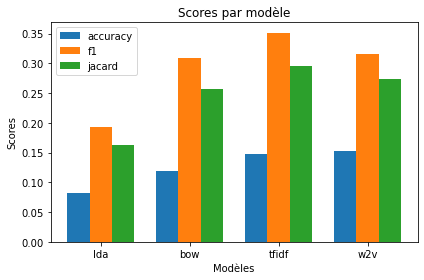

In [46]:
ind = np.arange(4) 
width = 0.25       
plt.bar(ind, eval_acc.values(), width, label='accuracy')
plt.bar(ind + width, eval_f1.values(), width, label='f1')
plt.bar(ind + (width * 2), eval_jac.values(), width, label='jacard')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Scores par modèle')

plt.xticks(ind + width, ['lda', 'bow', 'tfidf', 'w2v'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('test_result', dpi=100)
plt.show()